Import libraries


In [12]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 07 13:19:26 2024

@author: HART_C
@author: CRAIG HART clhart87@gmail.com

"""

# Automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

import toml
import os
import pandas as pd
import geopandas as gpd
from pathlib import Path
from matplotlib import pyplot as plt
from pyproj import CRS
import glob

from riselib.utils.logger import Logger

from riselib.plots import apply_iea_style, CM_FROM_IN

from riselib.palette import IEA_PALETTE_DICT, IEA_PALETTE_L8, IEA_PALETTE_D8, IEA_PALETTE_16, IEA_PALETTE_14
from riselib.palette import IEA_CMAP_L8, IEA_CMAP_D8, IEA_CMAP_16,IEA_CMAP_14
from riselib.palette import IEA_CMAP_RdYlGn_rl, IEA_CMAP_RdYlGn_rd, IEA_CMAP_RdYlGn_l ,IEA_CMAP_RdYlGn_d, IEA_CMAP_BlGnYlRd, IEA_CMAP_BlGnYlRd_d
from riselib.palette import IEA_CMAP_BlGnYlRdPu, IEA_CMAP_BlGnYlRdPu_d, IEA_CMAP_YlGnBl, IEA_CMAP_YlGnBl_d, IEA_CMAP_coolwarm_l, IEA_CMAP_coolwarm_d

from riselib.gis import get_country_gdf

log = Logger('profiles')


In [13]:
import model_setup as ms
c = ms.ModelConfig('../../config/UKR.toml')
# c = ms.ModelConfig('./config/CHN_2024_EFC.toml')

from model_setup.solution_index import SolutionIndexCreator
from model_setup.capacity_setup import CapacitySetup
from model_setup.transmission_setup import TransmissionSetup
from model_setup import LoadSetup


Function for building demand profiles that are read in by load_setup.py script

<Axes: >

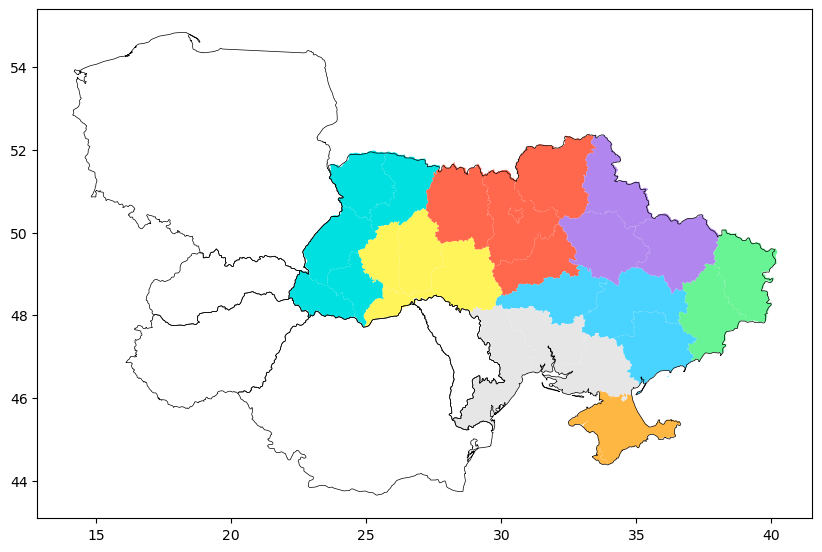

In [20]:
# This is necessary due to the bespoke nature of the setup procedure. The point of the script should be to provide regional splitting factors that can be 
fig, ax = plt.subplots(figsize=(10, 10))
c.gdf_adm.plot(ax=ax, cmap=IEA_CMAP_L8, column='PLEXOS_GRP1')
c.gdf_adm0.boundary.plot(ax=ax, color='k', linewidth=0.5)

#### Starts here

In [ ]:
def read_end_use_demand_WEO_format(file_path, sheet_vector, indexsheet  = "DSM_Index", StartRow = 1, RegionSplit = "", RegionVector = [], Scale_factor=1,
                                   end_use_adj_sheet = "", end_use_col = ""):
    
    ## create empty dataframe to contain results
    df = pd.DataFrame()
    
    ## read in region sheets one by one, melt and append
    ## very slow due to slowness of pd.read_excel
    for i in sheet_vector:
        # read in region sheet including end use headings and removing unwanted row
        demand_reg = pd.read_excel(file_path, sheet_name=i,header=[1]).iloc[1:,:].reset_index()
        #demand_reg = pd.read_excel(file_path, sheet_name=i,skiprows =StartRow-2, header=[1]).iloc[1:,:].reset_index()
        #demand_reg = pd.read_excel(file_path, sheet_name=i,startrow =(StartRow)).iloc[1:,:]
        # convert to long format
        dcm = pd.melt(demand_reg, id_vars = "Unnamed: 0")
        dcm.columns = (["datetime", "end_use", "value"])
        # add region column
        dcm.loc[:,'region'] = i
        # append to result dataframe
        df = df.append(dcm)
        
        
    ## read DSM index in order to trim end uses
    di = pd.read_excel(file_path, sheet_name = indexsheet)
    di = di[pd.notnull(di['Sector.Subsector'])]
    di = di[["Sector.Subsector", "Sheddability", "aggregate_type", "header"]]
    di.columns = ["end_use", "Sheddability", "aggregate_type", "header"]
    
    ## drop entries not corresponding with single end uses
    df = df[df.end_use.isin(np.unique(di.end_use))]
    init_sum = df["value"].sum()  
    
    ## merge
    df = pd.merge(df, di, how = "left")
    
    
    ## add datetime column for ordering, uses leap year to ensure feb is preserved if present
    ## this is a bit annoying but used to force [Month,Day,Hour] index to come out in the right order after pivoting
    colnames = df.columns.tolist()
    for i in ["Period","Day","Month"]:
        colnames.insert(0, i)
    df["Month"] = df.datetime.dt.month
    df["Day"] = df.datetime.dt.day
    df["Period"] = df.datetime.dt.hour + 1

    df = df[colnames]
    
    ## end use scaling if sheet / column are defined
    if len(end_use_adj_sheet) > 0:
        if end_use_col =="":
            print("Please define the column to refer to in the end use adjustment sheet")
        # read in end use totals 
        eua = pd.read_excel(file_path, sheet_name = end_use_adj_sheet).dropna()
        eua.loc[:,"eut"] = eua[end_use_col]
        print("End use scaling checks: Sum of end use target values: ", str(round(eua.eut.sum(), 0)))
        # merge with hourly frame
        dfeut = df.merge(eua[["end_use", "eut"]])
        # add column of sums by end use for comparison with target totals
        dfeut.loc[:,"end_use_sum"] = dfeut.groupby(["end_use"])["value"].transform("sum")/1000
        #adjust value based on ratio
        dfeut.loc[:,"value"] = dfeut["value"] * (dfeut.eut / dfeut.end_use_sum)
        print("Sum of values before scale: ", str(round(df["value"].sum()/1000, 0)))
        df = dfeut[colnames]
        print("Sum of values after scale: ", str(round(df["value"].sum()/1000, 0)))
    
    region_split_sum = 0
    
    if len(RegionSplit)>0:
        df.loc[:, 'scenario'] = df['region']
        df = df.drop(columns = 'region')
        regionsheet = pd.read_excel(file_path, sheet_name = RegionSplit)
        rs = pd.melt(regionsheet, id_vars = "end_use", value_vars = RegionVector, var_name= "region").rename(columns = {"value": "regionsplit"})
        df = pd.merge(df, rs, how = "left")
        df.loc[:,"orig_val"] = df["value"]
        df.loc[:,"value"] = df["orig_val"]*df["regionsplit"]
        split_sum = df["value"].sum()
    
    df["before_scale"] = df["value"]
    df.loc[:,"value"] = df["before_scale"]*Scale_factor
    scaled_sum = df["value"].sum()
    df.loc[:,"value"] = df.value.astype(np.float32)
    
    # return combined
    return df

In [ ]:
def add_time_separators(inputFrame, datetimeCol = "datetime", pattern_date = False, set_year = False, set_month = False,
                        timeconvention = "time_start"):
    
    df = inputFrame.copy(deep = True)
    dtcol = datetimeCol[:]
    if pattern_date == True:
        # create dummy datetime sequence using a leap or specified year and add merge info
        sd = dt(year=2020, month=1, day=1)
        if set_year != False:
            sd = dt(year = set_year, month = 1, day = 1)
            if set_month != False:
                sd = dt(year = set_year, set_month = 1, day = 1)
        dtdf = pd.DataFrame(pd.date_range(start=sd, end=sd+pd.offsets.DateOffset(years=1)+pd.offsets.DateOffset(hours=-1), freq='h'))
        dtdf.columns = ["datetime"]
        dtdf['month'] = pd.DatetimeIndex(dtdf.datetime).month
        dtdf['mday'] = pd.DatetimeIndex(dtdf.datetime).day
        dtdf['hour']= pd.DatetimeIndex(dtdf.datetime).hour
        # derive month day and hour info from pattern index
        df['month'] = df[dtcol].str.split(",").str[0].str.replace("M", "").astype(float)
        df['mday'] = df[dtcol].str.split(",").str[1].str.replace("D", "").astype(float)
        df['hour'] = df[dtcol].str.split(",").str[2].str.replace("H", "").astype(float) - 1
        
        #merge in dummy date sequence to allow remaining separators to be added as normal
        df = pd.merge(df, dtdf, how = "left")
        dtcol = "datetime"
        
    #df = df.set_index("datetime")
    if timeconvention == "time_end":
        df["original_datetime"] = df[dtcol]
        df["datetime"]= df["datetime"] - timedelta(hours=1)

    df['year'] = pd.DatetimeIndex(df[dtcol]).year
    df['month'] = pd.DatetimeIndex(df[dtcol]).month
    df['montht'] = pd.DatetimeIndex(df[dtcol]).month_name()
    df['week'] = df[dtcol].dt.isocalendar().week
    df['mday'] = pd.DatetimeIndex(df[dtcol]).day
    df['day'] = pd.DatetimeIndex(df[dtcol]).day
    df['yday'] = pd.DatetimeIndex(df[dtcol]).dayofyear
    df['hour']= pd.DatetimeIndex(df[dtcol]).hour
    df['pattern'] = "M" + df.month.astype(str) + ",D" + df.mday.astype(str) + ",H" +(df.hour+1).astype(str)
    df['wday_num'] = pd.DatetimeIndex(df[dtcol]).dayofweek
    df['wdaytype'] = "blank"
    df.loc[df['wday_num'].isin([0,1,2,3,4]), "wdaytype"] = "Weekday"
    df.loc[df['wday_num'].isin([5]), "wdaytype"] = "Saturday"
    df.loc[df['wday_num'].isin([6]), "wdaytype"] = "Sunday"
    df["seasonNH"] = "blank"
    df["seasonSH"] = "blank"
    df["two_seasonNH"] = "blank"
    df.loc[df['month'].isin([12, 1, 2]), "seasonNH"] = "Winter"
    df.loc[df['month'].isin([12, 1, 2]), "seasonSH"] = "Summer"
    df.loc[df['month'].isin([3,4,5]), "seasonNH"] = "Spring"
    df.loc[df['month'].isin([3,4,5]), "seasonSH"] = "Autumn"
    df.loc[df['month'].isin([6,7,8]), "seasonNH"] = "Summer"
    df.loc[df['month'].isin([6,7,8]), "seasonSH"] = "Winter"
    df.loc[df['month'].isin([9, 10, 11]), "seasonNH"] = "Autumn"
    df.loc[df['month'].isin([9, 10, 11]), "seasonSH"] = "Spring"
    
    df.loc[df['month'].isin([1, 2,3,10,11,12]), "two_seasonNH"] = "Winter"
    df.loc[df['month'].isin([4, 5, 6, 7, 8, 9]), "two_seasonNH"] = "Summer"
    

    #chk = df[df.month.isna()]

        
    if pattern_date == True:
        # strip off year (datetime column and year column) unless was specified
        if set_year == False:
            df = df.drop(["datetime", "year"], axis = 1)
    
    
    return(df)

In [ ]:
def convert_raw_load_to_PLEXOS_inputs(raw_load, index_path, save_path, indexsheet = "DSM_Index", hasAl = True, all_regs=None, loss_factor = 1):
    
    if all_regs==None:
        reg_filler = pd.Series(data = np.ones(len(demand_all.region.unique())), index = np.sort(demand_all.region.unique()))
    else:
        reg_filler = pd.Series(data = np.ones(len(all_regs)), index = np.sort(all_regs))
    
    
    """ read in DSM index elements that should not be aggregated and rename for merging where appropriate """
    di = pd.read_excel(index_path, sheet_name = indexsheet)
    di = di[pd.notnull(di['Sector.Subsector'])]
    di = di[["Sector.Subsector", "Sheddability", "aggregate_type", "header", "approx_unit", "max_scale", "max_shift"]]
    di.columns = ["end_use","Sheddability", "aggregate_type", "header", "approx_unit", "max_scale", "max_shift"]
    di_aggregate = di.groupby(["aggregate_type", "header"]).max().reset_index().drop(columns = "end_use")
    
    """ deep copy input variable (to avoid modification of source frame), scale to MW and generate scaled DSM value """
    df = raw_load.copy(deep = True)
    """replace index info in raw dataframe to ensure info from selected index is used """
    #df.columns
    df = df.drop(columns = ["Sheddability", "aggregate_type", "header"])
    df = pd.merge(df, di, how = "left")
    df = df.astype({'value':'float32', 'Sheddability':'float32'})
    df.loc[:,'value'] = df.value*1000*loss_factor
    # multiply each demand type by sheddability as per body of DSM sheets in excel version
    df.loc[:,"DSM"] = df.value * df.Sheddability

    idx_cols = ["Month", "Day", "Period", "datetime"]
    pattern_cols = ["Pattern" "datetime"]
    mdh_cols = ["Month", "Day", "Period"]
    
    """ create aggregated frame by aggregate type, header and region for use in multiple sections below
    as well as maxes frame for each aggregated end use """
    #create header aggregated frame 
    aggregated_DSM = (df.groupby(idx_cols + ["region", "aggregate_type", "header"])["DSM"].sum().unstack("region")*reg_filler).fillna(0).rename_axis(
    "region",axis=1).stack("region").rename("DSM").reorder_levels(idx_cols + ["region", "aggregate_type", "header"]).reset_index()

    # create header maxes frame for bids
    aggregated_DSM_maxes = aggregated_DSM.groupby(["region", "aggregate_type", "header"])[["DSM"]].max().reset_index()
    
    
    """ create total demands and write to .csv """
    totals = df.groupby(idx_cols + [ "region"])["value"].sum()
    totals_table = (totals.unstack("region")*reg_filler).fillna(0).reset_index()
    totals = totals.reset_index()  ### we could probably just use the pivot table approach for consistency
    totals_table.drop(columns = ["datetime"]).to_csv(save_path + "total_load.csv", index = False)
    
    """ create whole region, by end-use demand for checks (not used in model) """
    end_use_demands = df.groupby(idx_cols + [ "end_use"])[["value"]].sum().reset_index()
    end_use_table = end_use_demands.pivot_table(values = "value", index = idx_cols, columns = "end_use").reset_index()
    end_use_table.to_csv(save_path + "end_use_load_check.csv", index = False)
   
    """ create "native" load from totals minus shiftable demands """
    ## subset shiftable loads from aggregated frame
    shiftable = aggregated_DSM[aggregated_DSM.aggregate_type.isin(["shift_load"])]
    # aggregate for subtraction native load
    shiftable_totals = shiftable.groupby(idx_cols + [ "region"])["DSM"].sum().reset_index()

    ## merge with totals for subtraction and subtract
    native = pd.merge(totals, shiftable_totals, how = "left")
    native.loc[:,'value']  = native.value - native.DSM
    ## reshape and write to .csv
    native_table = (native.pivot_table(values = "value", index = idx_cols , columns = "region")*reg_filler).fillna(0).reset_index().drop(columns = ["datetime"])
    native_table.to_csv(save_path + "native_load.csv", index = False)
    """ create shiftable loads: load profile, daily sums, bid limits, max and min shifts, and annual limit for Aluminium """
    """ load profile - based on shiftable frame (already aggregated to shift category and region), create header """
    shiftable.loc[:,'NAME'] = shiftable.region + "_" + shiftable.header
    #np.unique(shiftable.header)
    ### reshape and write to .csv
    shiftable_table = shiftable.pivot_table(values = "DSM", index = idx_cols, columns = "NAME").reset_index().round(2)
    shiftable_table.drop(columns = ["datetime"]).to_csv(save_path + "DSM_shift.csv", index = False)
    """ daily sums """
    shift_sums = shiftable_table.set_index("datetime").drop(columns = mdh_cols)
    shift_sums = shift_sums.resample('D').sum()/1000 ## converted from MWh to GWh 
    round_places=5
    make_pattern_index(shift_sums).to_csv(save_path + "DSM_dayLimits.csv")
    """ bids """ #- merge in index
    bids = pd.merge(shiftable, di, how = "left")
    ## scale DSM value by max scale
    bids.loc[:,'value'] = bids.DSM*bids.max_scale
    ## find max value by region/shift category
    bids = bids.groupby(["NAME"])[["value"]].max().reset_index()
    ## add pattern column
    bids.loc[:,'pattern'] = "M1-12"
    ## set column names and write to .csv
    bids = bids[["NAME", "pattern", "value"]]
    bids.columns = ["NAME", "pattern", "1"]
    bids.to_csv(save_path + "DSM_bidQuantities.csv", index = False)
    """ max and min shift - tried changing this to monthly but produced infeasibilities
    agreed that annual max basis may be more reasonable anyway as demand response load is more coincident than unmanaged load
    so annual max basis may already be conservative """
    #np.unique(minmaxes.header)
    minmaxes = pd.merge(shiftable, di_aggregate, how = "left")
    minmaxes.loc[:,'1'] = minmaxes.DSM*minmaxes.max_shift
    ## drop null values
    minmaxes = add_time_separators(minmaxes[pd.notnull(minmaxes['1'])])
    minmaxes.loc[:,"NAME"] = minmaxes.region + "_MaxShift" + minmaxes.max_shift.astype(int).astype(str) + "h"
    ## find maxima of max shift values
    minmaxes = (minmaxes.groupby(["NAME"])["1"].max()*1.1).reset_index()
    #chkframe = minmaxes.groupby(["NAME"])["DSM"].max().reset_index()
    minmaxes.loc[:,'pattern'] = "M1-12"
    mins_frame = minmaxes.copy(deep = True)
    mins_frame.loc[:,'1'] = mins_frame['1']*-1
    mins_frame.NAME = mins_frame.NAME.str.replace("Max", "Min", case = True)
    minmaxes.append(mins_frame)[["NAME", "pattern", "1"]].to_csv(save_path + "DSM_MaxShift.csv", index = False)
    
    """ Aluminium annual limit """
    if hasAl == True:
        alframe = shiftable[shiftable.header == "Al"]
        alframe = alframe.groupby(["NAME"])[["DSM"]].sum().reset_index()
        alframe["1"] = alframe.DSM / 1000
        alframe["pattern"] = "M1-12"
        alframe[["NAME", "pattern", "1"]].to_csv(save_path + "Al_AnnualLim.csv", index = False)  
    
    """ create shed loads: units, max capacity per type, and rating per type and unit """
    """ units """
    # start with end use aggregates
    sheddable = aggregated_DSM[aggregated_DSM.aggregate_type.isin(["shed_load"])]
    # sheddable = sheddable[sheddable.region == "NER"]
    # sheddable = sheddable[sheddable.header == "Shed1h"]
    ## add unit size info
    sheddable = pd.merge(sheddable, di_aggregate, how = "left")
    sheddable.loc[:,"NAME"] = sheddable.region + "_" + sheddable.header
    # get max values and calculate number of units
    units = sheddable.groupby(["NAME"]).max().reset_index()
    units.loc[:,'1'] = round(units.DSM / units.approx_unit)
    # replace zeros with 1 if capacity is > 0
    units.at[(units["1"] == 0) & (units["DSM"] > 0) , "1"] = 1
    #units['1']
    units.loc[:,"pattern"] = "M1-12"
    units[["NAME", "pattern", "1"]].to_csv(save_path + "shed_units.csv", index = False)
    """ max capacity per type - calculate from DSM and units """
    units.loc[:,"size"] = units.DSM / units['1']
    unit_size = units[["NAME", "pattern", "size"]]
    unit_size.columns = ["NAME", "pattern", "1"]
    unit_size.to_csv(save_path + "shed_max_cap.csv", index = False)
    
    """ rating per type and unit by dividing through aggregated timeseries by number of units """
    sheddable_pu = pd.merge(sheddable, units[["NAME", "1"]], how = "left")
    sheddable_pu.DSM = sheddable_pu.DSM / sheddable_pu["1"]
    sheddable_pu.DSM = sheddable_pu.DSM.fillna(0)
    ## reshape and write to .csv
    sheddable_table = sheddable_pu.pivot_table(values = "DSM", index = idx_cols, columns = "NAME").reset_index().drop(columns = ["datetime"])
    sheddable_table.to_csv(save_path + "DSM_shed.csv", index = False)
    
    return("Processed successfully to: {}".format(save_path))

#### Process national demand for UKR

### Code to synthesize 2022 hourly data

In [1]:
save_dir = "Y:/Modelling/Ukraine/2023_UKR_ST_Security/"

### Process data inputs

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
spitting_file = "I:/DOCS/RISE-GER/UKR/Power_system_modernisation/Data/Key_data/UKR_population_by_region_2022.xlsx", 
splitting_sheet = "Population_feb2022"
splitting_header = 4


In [7]:
pop_by_reg = pd.read_excel("I:/DOCS/RISE-GER/UKR/Power_system_modernisation/Data/Key_data/UKR_population_by_region_2022.xlsx", sheet_name="Population_feb2022",
                          header=4).dropna(how='all', axis=1)

pop_by_reg = pop_by_reg[~(pop_by_reg.NAME_1.isna())]
pop_by_reg = pop_by_reg.set_index(['PLEXOS_GRP1', 'NAME_1'])

pop_by_reg = pop_by_reg.Pop_avg_202201

NameError: name 'c' is not defined

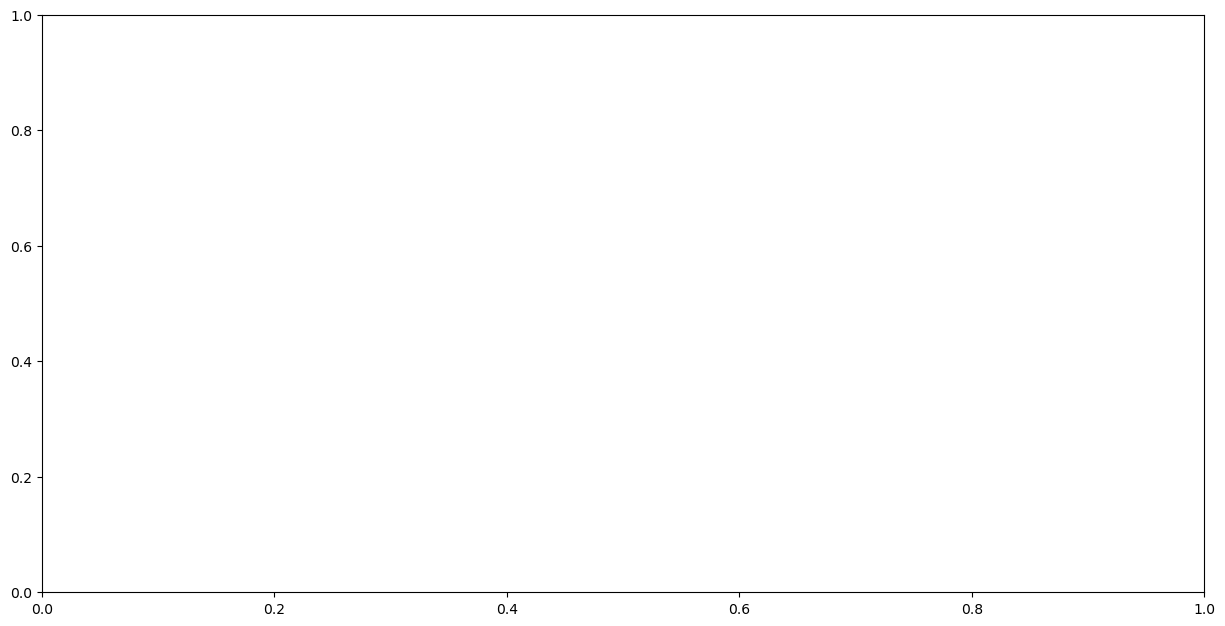

In [9]:
fig, ax = plt.subplots(1, figsize=(15, 7.5))


pd.merge(left=c.gdf_adm1, right=pop_by_reg.reset_index(), on=['NAME_1', 'PLEXOS_GRP1'], how='left').plot(ax=ax, column='Pop_avg_202201', legend=True,
                cmap = IEA_CMAP_RdYlGn_rd,
                missing_kwds={"color": "lightgrey", "label": "Missing values"},
                legend_kwds={'label': "Population by oblast (Average, January 2022)",
                                       'orientation': "vertical"})

apply_iea_style(ax)
plt.savefig(os.path.join(save_dir, "UKR_oblasts_by_population.png"))

In [ ]:
demand_by_sect_out = pd.DataFrame()
demand_by_sect_pc_out = pd.DataFrame()

years = ['2021', '2023']
for y in years:
    d = (demand_sector_dict[y].sum(axis=1)/demand_sector_dict[y].sum(axis=1).sum()).rename(y)
    demand_by_sect_pc_out = pd.concat([demand_by_sect_pc_out, d])
    
for y in years:
    d = (demand_sector_dict[y].sum(axis=1)).rename(y)
    demand_by_sect_out = pd.concat([demand_by_sect_out, d])
    
demand_by_sect_pc_out.to_csv('Y:/Modelling/Ukraine/2023_UKR_ST_Security/01_Data/02_Demand/demand_by_sect_shares.csv')
demand_by_sect_out.to_csv('Y:/Modelling/Ukraine/2023_UKR_ST_Security/01_Data/02_Demand/demand_by_sect_total.csv')



In [ ]:
demand_sector_dict['2021'].sum(axis=1)/demand_sector_dict['2021'].sum(axis=1).sum()
demand_sector_dict['2023'].sum(axis=1)/demand_sector_dict['2023'].sum(axis=1).sum()

### Estimation of generation

In [ ]:
# ### Split hourly demand using split in snapshots
# from solution_file_processing.utils.write_excel import write_xlsx_column, write_xlsx_stack, STACK_PALETTE
# import openpyxl as xl 
  
# modelled_regs = ['Ukraine', 'CR', 'ER', 'NR', 'SR', 'SWR', 'SR', 'EOR']
# demand_sector_dict = {}
# demand_by_reg_df = pd.DataFrame(None)

# folder_path = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/01_Data/02_Demand'
# demand_file_paths = [f for f in os.listdir(folder_path) if ('demand' in f) &('$' not in f)]

# # for path in demand_file_paths:
# for path in demand_file_paths:

#     full_path = os.path.join(folder_path, path)
#     # load the workbook 
#     wb = xl.load_workbook(full_path)     
#     sheet_names = wb.sheetnames
#     est_gen_by_tech_df = {}

#     for reg in sheet_names:

#         aux_loss_df = pd.read_excel(full_path, sheet_name=reg, header=7, usecols='A:Z', nrows = 52)
        
#         aux_loss_df = aux_loss_df.loc[aux_loss_df['consumer groups'].str.contains('needs'),:]
#         aux_loss_df = aux_loss_df.iloc[1:,]

#         rename_cols = {"The CHP's own needs":"CHP",
#                             "Own needs of HPP": "Hydro",
#                             "The NPP's own needs":"Nuclear",
#                             "Production needs":"Thermal"}
        
#         aux_loss_df['consumer groups'] = aux_loss_df['consumer groups'].apply(lambda x: rename_cols[x])
#         aux_loss_df = aux_loss_df.rename(columns={'consumer groups':'Tech'}).set_index('Tech').drop(columns='line').T.rename_axis('Hour')

            
#         aux_losses_by_tech = pd.Series({'CHP':0.05, ## Gas is 4%, coal is 6% 
#                             'Hydro':0.01,
#                             'Nuclear':0.06,
#                             'Thermal':0.05})
        
#         tech_palette = {'CHP':'grey20', ## Gas is 4%, coal is 6% 
#                             'Hydro':'bl',
#                             'Nuclear':'p',
#                             'Thermal':'brown'}
        
#         est_gen_by_tech_df[reg] = aux_loss_df/aux_losses_by_tech

#         with pd.ExcelWriter(os.path.join(folder_path,'est_gen_snapshot_.xlsx'.format(path[-13:])),
#                             engine="xlsxwriter") as writer:
#             # ExcelWriter for some reason uses writer.sheets to access the sheet.
#             # If you leave it empty it will not know that sheet Main is already there
#             # and will create a new sheet.

#             for reg in est_gen_by_tech_df.keys():
#                 write_xlsx_stack(df=est_gen_by_tech_df[reg],
#                                     writer=writer,
#                                     sheet_name=reg,
#                                     palette=tech_palette)
#                 print(f'Created sheet "{reg}" in {folder_path}.')
        


### Now including test stuff to add 2022/2023 demand using obtained splitting factors from demand snapshots

In [ ]:
### Split historical demand by 2021 values. Not using 2022 demand (though we could until October for 2022 really. To add)
historical_demand_idx =  pd.date_range(start='01-01-2015', end='31-12-2021 23:00', freq='1H')
hist_demand_by_reg = pd.DataFrame(index=historical_demand_idx)
# For comparison of 2022 values with those by splitting factor by snapshot
ref_hist_demand_by_reg = pd.DataFrame(index=demand_hourly.index)

for i in demand_by_reg_pc_df['2021'].index:
    hist_demand_by_reg[i] = demand_hourly[demand_hourly.index.year <= 2021]*demand_by_reg_pc_df['2021'][i]
    ### For comparison with obtained 2022 values
    ref_hist_demand_by_reg[i] = demand_hourly*demand_by_reg_pc_df['2021'][i]

In [ ]:
demand_by_reg_pc_df.sum()

In [ ]:
### Obtain 2022 - 2023 demand 
base_demand_hourly = demand_hourly[demand_hourly.index.year ==2021]

for year in [2022, 2023]:
    ext_hist_demand_idx = pd.date_range(start='01-01-{}'.format(year), end='31-12-{} 23:00'.format(year), freq='1H')
    ext_hist_demand_by_reg = pd.DataFrame(index=ext_hist_demand_idx)
    
    ## Only use 2022 split as it allows us to use the actual 2022 demand for corrective scaling
    for i in demand_by_reg_pc_df[str(2022)].index:
        ext_hist_demand_by_reg[i] = base_demand_hourly.values*demand_by_reg_pc_df[str(2022)][i]
    
    hist_demand_by_reg = pd.concat([hist_demand_by_reg, ext_hist_demand_by_reg ], axis=0)


In [ ]:
hist_demand_by_reg.sum(axis=1).plot()

In [ ]:
### Compare 2022 demand (forecasted through snapshot and actuals)

hist_demand_2022 = ref_hist_demand_by_reg[(ref_hist_demand_by_reg.index.year == 2022)].sum(axis=1).rename('Historical')
for_demand_2022 = hist_demand_by_reg.loc[hist_demand_2022.index,:].sum(axis=1).rename('Forecasted')

### This plot (above) clearly shows that there is a slight mismatch in demand based on the methodology.
### This most likely due to the very cold winter that took place in 2021/2022 and so is ignored for this reason.

corrective_scaling_factor = hist_demand_2022.sum()/for_demand_2022.sum()   

## For comparison, we calculate the scaling factor if targeting 18 GW
## 18 GW is the expected demand for for Winter 2024/25
## based on https://greendealukraina.org/products/analytical-reports/six-options-to-boost-power-grid-transfers-from-continental-europe-to-ukraine-for-the-next-two-winters

corrective_scaling_factor_2023 = 18.5e3 / hist_demand_by_reg[hist_demand_by_reg.index.year == 2023].sum(axis=1).max()

## Plot to see the differences
pd.concat([hist_demand_2022,for_demand_2022], axis=1).plot()



In [ ]:
print(f'Corrective scaling based on estimates: {np.round(corrective_scaling_factor,3)} vs. that based on target: {np.round(corrective_scaling_factor_2023,3)}')

In [ ]:
### Apply corrective scaling factor to all regions for obtaining 18GW peak winter demand
### Not applied to 2023 as we assume the Winter/Winter (Dec/Feb) scaling factor calculated from then snapshot holds
hist_demand_by_reg.loc[hist_demand_by_reg.index.year == 2022, :] = hist_demand_by_reg.loc[hist_demand_by_reg.index.year == 2022, :] * corrective_scaling_factor
hist_demand_by_reg.loc[hist_demand_by_reg.index.year == 2023, :] = hist_demand_by_reg.loc[hist_demand_by_reg.index.year == 2023, :] * corrective_scaling_factor_2023

hist_demand_by_reg = pd.concat([ref_hist_demand_by_reg, hist_demand_by_reg[~hist_demand_by_reg.index.isin(ref_hist_demand_by_reg.index)]], axis=0)

In [ ]:
pd.concat([hist_demand_by_reg.sum(axis=1).rename('full'), 
           ref_hist_demand_by_reg.sum(axis=1).rename('hist')], axis=1).plot()

In [ ]:
ref_hist_demand_by_reg[ref_hist_demand_by_reg.index.year==2022].sum(axis=1).plot()

In [ ]:
hist_demand_by_reg.sum(axis=1).groupby(pd.Grouper(freq='Y')).max()

nzw_demand#### NZW demand curves!

In [ ]:
### Seasonality profile (daily) across seasons is calculated to scale 4Q seasonal demand to full 365 days of variable demand

### Annual demand to check against annual sums at the end

months_of_seasons = {'R': [4,5,6], 'S':[7,8,9], 'T':[10,11,12], 'W':[1,2,3]}
seasons_months = {1:'W',2:'W',3:'W',4:'R',5:'R',6:'R',7:'S',8:'S',9:'S',10:'T',11:'T',12:'T'}


# annual_demand = future_demand.sum()
daily_sums = ref_hist_demand_by_reg[ref_hist_demand_by_reg.index.year==2021].sum(axis=1).groupby(pd.Grouper(freq='1D')).sum()
seasonal_avg_daily_sum = ref_hist_demand_by_reg[ref_hist_demand_by_reg.index.year==2021].sum(axis=1).groupby(pd.Grouper(freq='1D')).sum().groupby(
    lambda x : seasons_months[x.month]).mean()
seasonal_end_dates = {'R': '2021-06-30', 'S':'2021-09-30', 'T': '2021-12-31', 'W':'2021-03-31' }
seasonal_avg_daily_sum.index = pd.to_datetime(seasonal_avg_daily_sum.to_frame().reset_index()['index'].apply(
    lambda x: seasonal_end_dates[x]))
seasonal_avg_daily_sum = seasonal_avg_daily_sum.sort_index()

#### Based on 4Q seasonality
### Obtain daily seasonality profile and then convert to hourly index ==> 2025 index
seasonality_profile = daily_sums/seasonal_avg_daily_sum.reindex(daily_sums.index).fillna(method='bfill')
### first based on 2021 index as tis is the base profile year
seasonality_profile = seasonality_profile.reindex(pd.date_range(start='01-01-2021', end='31-12-2021 23:00', freq='1H')).fillna(method='ffill')

In [ ]:
future_demand_dict = {}


In [ ]:
loss_factor = 1
data_dir = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/01_Data/'

### Get demand for 2025 and 2030 for all scenarios
for year in [2025,2030]:
    ### To house all scenarios for single year
    time_idx = pd.date_range(start='01-01-{}'.format(year), end='31-12-{} 23:00'.format(year), freq='1H')
    future_demand = pd.DataFrame(index=time_idx)
    
    ### This was using NZW demand curves for each scenario. The curves look weird for IR and BR, 
    ### so only BAU should be used, and then scaled accordingly
    ### The rest (scaling by total power generation, etc.) remains unchanged.
    ### This should somehow be imported to the plexos-model-setup setup .... TODO
    for scen in ['BAU', 'BR', 'IR']:
        nzw_demand = pd.read_excel(os.path.join(data_dir,
                            '02_Demand/NZW/Load_curve_{}.xlsx'.format(year)), 
                            sheet_name=scen, header=1)
        nzw_demand = nzw_demand.drop(columns=['unit']).set_index('sub-sector')

        nzw_demand = nzw_demand[nzw_demand.sum(axis=1) < 0].sum(axis=0)
        
        nzw_elec_gen = pd.read_excel(os.path.join(data_dir,
                            '01_Generation/NZW/NZW_elecgen_{}.xlsx'.format(scen)),
                            header=1).set_index('sub-sector').drop(columns='unit')
        
        nzw_elec_gen = nzw_elec_gen[nzw_elec_gen.index != 'Export'].sum()
        
        for s in months_of_seasons.keys():
            s_demand = nzw_demand[nzw_demand.index.str.contains(s)]
            s_demand.index = s_demand.index.str[-2:].astype(int)
            for h in s_demand.index:
                future_demand.loc[(future_demand.index.hour + 1 == h) & (future_demand.index.month.isin(months_of_seasons[s])), scen] = -s_demand[h]
    
                                         
        ### Load curve 2025 doesnt match up with total demand/generation. 
        ### Therefore we need to scale
        future_demand_scale = nzw_elec_gen[year]/(future_demand.loc[:,scen].sum()/1000)
        future_demand.loc[:,scen] = future_demand.loc[:,scen] * future_demand_scale
        
#     ### Apply seasonality based on 2021 profiles
#     seasonality_scale = seasonality_profile.copy()
#     seasonality_scale.index = future_demand.index

#     ### Scale
#     future_demand =  future_demand * seasonality_scale.values[:, None]
    future_demand_dict[year] = future_demand


In [ ]:
### Use load curves !!

loss_factor = 1
data_dir = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/01_Data/'

### Get demand for 2025 and 2030 for all scenarios
for year in [2030]:
    ### To house all scenarios for single year
    time_idx = pd.date_range(start='01-01-{}'.format(year), end='31-12-{} 23:00'.format(year), freq='1H')
    future_demand = pd.DataFrame(index=time_idx)
    
    ### This was using NZW demand curves for each scenario. The curves look weird for IR and BR, 
    ### so only BAU should be used, and then scaled accordingly
    ### The rest (scaling by total power generation, etc.) remains unchanged.
    ### This should somehow be imported to the plexos-model-setup setup .... TODO
    future_demand = pd.DataFrame()
    for scen in ['BAU', 'BR', 'IR']:
        nzw_demand = pd.read_csv(os.path.join(data_dir,
                            f'02_Demand/UA_profile_forecasting/UA_Forecasted_2030_{scen}.csv'), 
                            header=0)
        nzw_demand = nzw_demand.set_index(['Year', 'Month', 'Day', 'Period'])
        nzw_demand.index = time_idx
        future_demand = pd.concat([future_demand, nzw_demand.rename(columns={'1':scen})], axis=1)
        
        
                                         
        #
        
#     ### Apply seasonality based on 2021 profiles
#     seasonality_scale = seasonality_profile.copy()
#     seasonality_scale.index = future_demand.index

#     ### Scale
#     future_demand =  future_demand * seasonality_scale.values[:, None]
    future_demand_dict[year] = future_demand/1000


In [ ]:
# ### To account for stagnant growth 2023-2025 and impacts of ongoing war
load_growth_factor_orig =  future_demand_dict[2030].sum()/future_demand_dict[2025].sum()

In [ ]:
### BAU demand for 2025 should be the same as 2022/2023
future_demand_dict[2025].loc[:,'BAU'] = hist_demand_by_reg[hist_demand_by_reg.index.year==2023].sum(axis=1).values/1000
future_demand_dict[2025].loc[:,'BR'] = hist_demand_by_reg[hist_demand_by_reg.index.year==2023].sum(axis=1).values/1000
future_demand_dict[2025].loc[:,'IR'] = hist_demand_by_reg[hist_demand_by_reg.index.year==2023].sum(axis=1).values/1000

In [ ]:
load_growth_factor_new =  future_demand_dict[2030].sum()/future_demand_dict[2025].sum()

In [ ]:
scaling_factor = load_growth_factor_new/load_growth_factor_orig
scaling_factor

In [ ]:
# load_growth_factor_new =  future_demand_dict[2030].sum()/future_demand_dict[2025].sum()
future_demand_dict_scaled = future_demand_dict.copy()
future_demand_dict_scaled[2030] = future_demand_dict_scaled[2030]/load_growth_factor_new*load_growth_factor_orig

In [ ]:
future_demand_dict[2030].sum()

In [ ]:
# future_demand_dict = future_demand_dict_scaled

In [ ]:
### Once the demand is obtained, we can try fill in the demand profiles for the in-between years (ignoring leap days for now)
for year in np.arange(2026,2030):
    time_idx = pd.date_range(start='01-01-{}'.format(year), end='31-12-{} 23:00'.format(year), freq='1H')
    time_idx_no_leap = time_idx[~((time_idx.month==2)&(time_idx.day==29))]
    future_demand = future_demand_dict[2025].values + (future_demand_dict[2030] - future_demand_dict[2025].values)/(2030-2025)*(year-2025)
    
    ### Deal with leap day aspects
    future_demand.index = time_idx_no_leap
    future_demand = future_demand.reindex(time_idx)
    future_demand = future_demand.fillna(future_demand.shift(-24))
    future_demand_dict[year] = future_demand

In [ ]:
### Once the demand is obtained, we can try fill in the demand profiles for the in-between years (ignoring leap days for now)
for year in np.arange(2026,2030):
    time_idx = pd.date_range(start='01-01-{}'.format(year), end='31-12-{} 23:00'.format(year), freq='1H')
    time_idx_no_leap = time_idx[~((time_idx.month==2)&(time_idx.day==29))]
    future_demand = future_demand_dict[2025].values + (future_demand_dict[2030] - future_demand_dict[2025].values)/(2030-2025)*(year-2025)
    
    ### Deal with leap day aspects
    future_demand.index = time_idx_no_leap
    future_demand = future_demand.reindex(time_idx)
    future_demand = future_demand.fillna(future_demand.shift(-24))
    future_demand_dict[year] = future_demand

In [ ]:
### Merge with historical profiles

scen_series_filler = pd.Series({'BAU':1, 'IR':1, 'BR':1 })
hist_demand_by_scen = scen_series_filler.apply(lambda x: x*hist_demand_by_reg.sum(axis=1)).T

In [ ]:
### 2024 interpolation for demand (using historical / future demand mix for UKR)

interp_demand_2024 = future_demand_dict[2025] - (future_demand_dict[2025].values - hist_demand_by_scen[hist_demand_by_scen.index.year==2023].values/1000) / (2025-2023) *(2024 -2023)

time_idx = pd.date_range(start='01-01-2024'.format(year), end='31-12-2024 23:00'.format(year), freq='1H')
time_idx_no_leap = time_idx[~((time_idx.month==2)&(time_idx.day==29))]
interp_demand_2024.index = time_idx_no_leap

interp_demand_2024 = interp_demand_2024.reindex(time_idx)
interp_demand_2024 = interp_demand_2024.fillna(interp_demand_2024.shift(-24))
future_demand_dict[2024] = interp_demand_2024


### Create demand by scenario using all years
demand_by_scen = pd.DataFrame(None)
for year in list(set(future_demand_dict.keys())):
    demand_by_scen = pd.concat([demand_by_scen, future_demand_dict[year]], axis=0)

In [ ]:
future_demand_dict_scaled[2030].sum()

#### Split future demand (national) and add to scenario-based dict

In [ ]:
def output_as_plexos_csv(df, output_dir, output_name):
    '''Add columns for Year, Month, Day and Hour'''    
    out_df = df.copy()
    out_df['Year'] = out_df.index.year
    out_df['Month'] = out_df.index.month
    out_df['Day'] = out_df.index.day
    out_df['Period'] = out_df.index.hour+1 ### Hours 1-24 in PLEXOS
    
    if ".csv" not in output_name:
        output_name = "{}.csv".format(output_name)
    
    out_path = os.path.join(output_dir, output_name)
    
    if os.path.exists(output_dir) is False:
        os.mkdir(output_dir)
        print("New directory created at {}".format(output_dir))
        
    
    out_df.reset_index(drop=True).set_index(['Year', 'Month', 'Day', 'Period']).to_csv(out_path)
    print("Output file saved at {}".format(out_path))

In [ ]:
future_demand_by_reg_pc = demand_by_reg_pc_df['2022']/demand_by_reg_pc_df['2022'].sum()
future_demand_by_reg_pc.to_csv('Y:/Modelling/Ukraine/2023_UKR_ST_Security/01_Data/demand_split_reg_2022.csv')

In [ ]:
future_demand_by_reg_pc = demand_by_reg_pc_df['2023']/demand_by_reg_pc_df['2023'].sum()
future_demand_by_reg_pc.to_csv('Y:/Modelling/Ukraine/2023_UKR_ST_Security/01_Data/demand_split_reg_2023.csv')

In [ ]:
### Split using the 2023 splitting factors (that is from the demand snapshot from Feb 2023 or thereabouts )
demand_by_reg_dict = {}
future_demand_by_scen = demand_by_scen[demand_by_scen.index.year >= 2024]

for scen in ['BAU', 'IR', 'BR']:
    future_demand_by_reg = pd.DataFrame(index=future_demand_by_scen.index)
    for reg in demand_by_reg_pc_df['2022'].index:
        future_demand_by_reg[reg] = future_demand_by_scen[scen]*future_demand_by_reg_pc[reg]*1000
    
    demand_by_reg_dict[scen] = pd.concat([hist_demand_by_reg, future_demand_by_reg], axis=0)

In [ ]:
# output_as_plexos_csv(demand_by_reg, save_dir, "total_load_{}.csv".format(scen))


In [ ]:
# demand_by_reg

### EU demand

In [ ]:
eu_isos = [
  'AUT', 'BGR','HRV', 'CZE',  'DEU', 'HUN',  'LTU',
  'POL', 'ROU', 'SVK'
]

In [ ]:
### Read in historical demand
eu_hist_demand_path = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/01_Data/03_EU_data/EU_Input_Data/EU_Hourly_Demand.csv'
eu_hist_demand = pd.read_csv(eu_hist_demand_path)
eu_hist_idx = pd.date_range(start='01-01-2015', end='31-12-2023 23:00', freq='1H')
eu_hist_demand.index = eu_hist_idx
eu_hist_demand = eu_hist_demand[eu_isos]

### Filter out erroneous values from ENTSOE data
eu_hist_demand = std_screen_cols(eu_hist_demand)

fig, ax = plt.subplots(1, figsize=(7.5, 5))
eu_hist_demand.plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
eu_regs = {
  'AUT':'AT00', 'BGR':'BG00','HRV':'HR00', 'CZE':'CZ00',  'DEU':'DE00', 'HUN':'HU00',
   'LTU':'LT00', 'POL':'PL00', 'ROU':'RO00', 'SVK':'SK00'}


eu_demand_dict = {}

for year in [2025, 2028, 2030]:
    
    ### Use 2025 in all cases as 2028 doesnt have leap day
    time_idx = pd.date_range(start='01-01-{}'.format(year), end='31-12-{} 23:00'.format(year), freq='1H')
    time_idx_no_leap = time_idx[~((time_idx.month==2)&(time_idx.day==29))]
    
    eu_year_demand_dict = {}
    year_demand = pd.DataFrame(None)
    year_choice = 2016 ## This is arbitrary. Could there be good rationale for year selection (e.g. median? peak median?)
    
    for reg in eu_regs:
        
        reg_demand = pd.read_excel('Y:/Modelling/Ukraine/2023_UKR_ST_Security/01_Data/03_EU_data/Demand_Timeseries_TY{}_UKR_subset.xlsx'.format(year),sheet_name=eu_regs[reg], header=1)      
        year_demand  = pd.concat([year_demand, reg_demand[year_choice].rename(reg)],axis=1)
    
    year_demand.index = time_idx_no_leap
    eu_demand_dict[year] = year_demand

In [ ]:
### Years for interpolating data for  included in ENTSOE 
interp_ref_years = {2026:[2025, 2028], 2027:[2025, 2028], 2029:[2028,2030]}

for year in interp_ref_years.keys():
    
    interp_demand = eu_demand_dict[interp_ref_years[year][0]] + \
    (eu_demand_dict[interp_ref_years[year][1]].values - eu_demand_dict[interp_ref_years[year][0]].values) / \
    (interp_ref_years[year][1]-interp_ref_years[year][0])*(year-interp_ref_years[year][0])
    
    time_idx = pd.date_range(start='01-01-{}'.format(year), end='31-12-{} 23:00'.format(year), freq='1H')
    time_idx_no_leap = time_idx[~((time_idx.month==2)&(time_idx.day==29))]
    interp_demand.index = time_idx_no_leap

    eu_demand_dict[year] = interp_demand

In [ ]:
### Calculate 2024 demand specifically using the combo of historical and forecasted demand!

interp_demand_2024 = eu_hist_demand[eu_hist_demand.index.year==2023] + \
    (eu_demand_dict[2025].values - eu_hist_demand[eu_hist_demand.index.year==2023].values) / \
    (2025-2023)*(2024 - 2023)
    
time_idx = pd.date_range(start='01-01-2024'.format(year), end='31-12-2024 23:00'.format(year), freq='1H')
time_idx_no_leap = time_idx[~((time_idx.month==2)&(time_idx.day==29))]
interp_demand_2024.index = time_idx_no_leap

eu_demand_dict[2024] = interp_demand_2024

In [ ]:
future_eu_demand = pd.DataFrame(None)

for year in list(set(eu_demand_dict.keys())):
    
    year_demand = eu_demand_dict[year]
    time_idx = pd.date_range(start='01-01-{}'.format(year), end='31-12-{} 23:00'.format(year), freq='1H')
    
    
    ### Reindex and repeat 28th Feb demand if its a leap year (as an extra day would be present)
    year_demand = year_demand.reindex(time_idx)
    year_demand = year_demand.fillna(year_demand.shift(-24))
    
    future_eu_demand = pd.concat([future_eu_demand, year_demand], axis=0)

eu_demand_full = pd.concat([eu_hist_demand, future_eu_demand], axis=0)

fig, ax = plt.subplots(1, figsize=(7.5, 5))
eu_demand_full.plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

##  Outputs

In [ ]:

from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates

scen='IR'
save_dir = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/'
demand_by_reg = demand_by_reg_dict[scen]
demand_by_reg = demand_by_reg[[c for c in demand_by_reg.columns if c != 'CRM']].sort_index(axis=1).groupby(pd.Grouper(freq='M')).sum()/1e6
x1, x2 = demand_by_reg.index.year.min(), demand_by_reg.index.year.max()
# demand_by_country = pd.concat([demand_by_reg.sum(axis=1).rename('UKR'), eu_demand_full], axis=1)
demand_by_reg.index =  [pd.to_datetime(date, format='%Y-%m-%d').date() for date in  demand_by_reg.index]

fig, ax = plt.subplots(1, figsize=(10, 5))
demand_by_reg.plot(ax=ax, kind='area', stacked=True, cmap=reg_cmap_noCRM_d)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlim(demand_by_reg.index[0], demand_by_reg.index[-1])
ax.set_ylabel('TWh')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_ylim(0,20)


fig.savefig(os.path.join(save_dir, 'monthly_demand{}.png'.format(scen)))

In [ ]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates

scen='BR'
save_dir = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/'
demand_by_reg = demand_by_reg_dict[scen]
demand_by_reg = demand_by_reg[[c for c in demand_by_reg.columns if c != 'CRM']].sort_index(axis=1).groupby(pd.Grouper(freq='M')).sum()/1e6
x1, x2 = demand_by_reg.index.year.min(), demand_by_reg.index.year.max()
# demand_by_country = pd.concat([demand_by_reg.sum(axis=1).rename('UKR'), eu_demand_full], axis=1)
demand_by_reg.index =  [pd.to_datetime(date, format='%Y-%m-%d').date() for date in  demand_by_reg.index]

fig, ax = plt.subplots(1, figsize=(10, 5))
demand_by_reg.plot(ax=ax, kind='area', stacked=True, cmap=reg_cmap_noCRM_d)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlim(demand_by_reg.index[0], demand_by_reg.index[-1])
ax.set_ylabel('TWh')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_ylim(0,20)


fig.savefig(os.path.join(save_dir, 'monthly_demand_{}.png'.format(scen)))

In [ ]:
from matplotlib.ticker import FormatStrFormatter

scen='BAU'
save_dir = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/'
demand_by_reg = demand_by_reg_dict[scen]
demand_by_reg = demand_by_reg[[c for c in demand_by_reg.columns if c != 'CRM']].sort_index(axis=1).groupby(pd.Grouper(freq='M')).sum()/1e6
x1, x2 = demand_by_reg.index.year.min(), demand_by_reg.index.year.max()
# demand_by_country = pd.concat([demand_by_reg.sum(axis=1).rename('UKR'), eu_demand_full], axis=1)
demand_by_reg.index =  [pd.to_datetime(date, format='%Y-%m-%d').date() for date in  demand_by_reg.index]

fig, ax = plt.subplots(1, figsize=(10, 5))
demand_by_reg.plot(ax=ax, kind='area', stacked=True, cmap=reg_cmap_noCRM_d)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlim(demand_by_reg.index[0], demand_by_reg.index[-1])
ax.set_ylabel('TWh')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_ylim(0,20)


fig.savefig(os.path.join(save_dir, 'monthly_demand_{}.png'.format(scen)))

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.ticker as ticker


def apply_iea_style_plot(ax):
    ### Remove frame
    sns.despine(ax=ax, left=False, top=True, bottom= False, right=True)

    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['legend.title_fontsize'] = 10
    plt.rcParams['font.family'] = 'Arial'



    ## Plot gridlines etc below the map
    ax.set_axisbelow(True)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, scen in enumerate(['BAU', 'BR', 'IR']):
    save_dir = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/'
    demand_by_reg = demand_by_reg_dict[scen]
    demand_by_reg = demand_by_reg[[c for c in demand_by_reg.columns if c != 'CRM']].sort_index(axis=1).groupby(pd.Grouper(freq='Y')).sum()/1e3
    demand_by_reg = demand_by_reg/1000
    # demand_by_country = pd.concat([demand_by_reg.sum(axis=1).rename('UKR'), eu_demand_full], axis=1)
    demand_by_reg.plot(ax=ax[i], kind='area', cmap=reg_cmap_noCRM_d).plot(ax=ax, stacked=True, cmap=reg_cmap_noCRM_d, legend=False)
    ax[i].set_title(scen)
    ax[i].set_ylim(0, 250)
    ax[i].get_legend().remove()
    ax[0].set_ylabel('TWh')

#     apply_iea_style_plot(ax[i])


ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(os.path.join(save_dir, 'annual_demand_by_reg.png'))



In [ ]:
### Output summary for plotting in IEA format
save_dir = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/'

# Write each DataFrame to a different sheet in an Excel file
with pd.ExcelWriter(os.path.join(save_dir,'demand_by_scenario.xlsx')) as writer:
    for sheet_name, df in demand_by_reg_dict.items():
        df = df[[c for c in df.columns if c != 'CRM']].sort_index(axis=1).groupby(pd.Grouper(freq='Y')).sum()/1e3
        df = df/1000
        df.to_excel(writer, sheet_name=sheet_name, index=True) 

In [ ]:
### Output summary for plotting in IEA format
save_dir = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/'

# Write each DataFrame to a different sheet in an Excel file
with pd.ExcelWriter(os.path.join(save_dir,'pk_demand_by_scenario.xlsx')) as writer:
    for sheet_name, df in demand_by_reg_dict.items():
        df = df[[c for c in df.columns if c != 'CRM']].sum(axis=1).groupby(pd.Grouper(freq='Y')).max()/1e3
        df.to_excel(writer, sheet_name=sheet_name, index=True) 

In [ ]:

for scen in demand_by_reg_dict.keys():
    save_dir = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/03_Modelling/01_InputData/02_DemandSide/NEW/'
    demand_by_reg = demand_by_reg_dict[scen]
    demand_by_reg['CRM'] = 0 
    demand_by_reg = pd.concat([demand_by_reg, eu_demand_full], axis=1)
    
    ##  Check if save_dir exists....o|therwise make new directory

    output_as_plexos_csv(demand_by_reg, save_dir, "total_load_{}.csv".format(scen))
    output_as_plexos_csv(demand_by_reg, save_dir, "native_load_{}.csv".format(scen))
    

### Output columns for all regions etc to populate the Purchaser stuff for the standard PLEXOS model

In [ ]:
### Other files, not currently used, could generate here with appropriate inputs

time_series_inputs = ['EV', 'Shift1h','Shift5h', 'Shift8h', 'Al', 'Elec']


In [ ]:
all_regs = list(demand_by_reg.columns)
all_regs = all_regs + ['CRM']

In [ ]:
out_all = pd.DataFrame(None)
for f in time_series_inputs:
    out = pd.DataFrame(index = demand_by_reg.index, columns=[i + '_' + f for i in all_regs]).fillna(0)
    out_all = pd.concat([out_all, out], axis=1)

out_all['Year'] = out_all.index.year 
out_all['Month'] = out_all.index.month
out_all['Day'] = out_all.index.day
out_all['Period'] = out_all.index.hour + 1

idx_cols = ['Year', 'Month', 'Day', 'Period']
out_all = out_all[idx_cols + [c for c in out_all if c not in idx_cols]]


In [ ]:
out_all.to_csv(os.path.join(save_dir, 'DSM_Shift.csv'), index=False)

#### Test stuff for UKR demand models

In [ ]:
ukr_re_data = pd.read_excel('Y:/Modelling/Ukraine/2023_UKR_ST_Security/01_Data/01_Generation/2021_12_31_en_vstanovlena_potuzhnist_vde_EDITED.xlsx',
                           sheet_name='Data')

In [ ]:
ukr_re_data = ukr_re_data.dropna(how='all', axis=1)

In [ ]:
ukr_re_data.columns

In [ ]:
 ukr_re_data.head()

In [ ]:
save_dir = 'Y:/Modelling/Ukraine/2023_UKR_ST_Security/'

In [ ]:
re_by_time = ukr_re_data.groupby(['Date start', 'Tech']).agg({'Installed capacity, MW': 'sum'})['Installed capacity, MW'].unstack('Tech')
re_by_reg = ukr_re_data[(ukr_re_data.Year==2021)&(ukr_re_data.Month==12)].groupby(['PLEXOS_GRP1', 'Tech']).agg({'Installed capacity, MW': 'sum'})['Installed capacity, MW'].unstack('Tech')
re_by_oblast = ukr_re_data[(ukr_re_data.Year==2021)&(ukr_re_data.Month==12)].groupby(['PLEXOS_GRP1','NAME_1', 'Tech']).agg({'Installed capacity, MW': 'sum'})['Installed capacity, MW'].unstack('Tech')

In [ ]:
re2_by_time = ukr_re_data.groupby(['Date start', 'Tech2']).agg({'Installed capacity, MW': 'sum'})['Installed capacity, MW'].unstack('Tech2')
re2_by_reg = ukr_re_data[(ukr_re_data.Year==2021)&(ukr_re_data.Month==12)].groupby(['PLEXOS_GRP1', 'Tech2']).agg({'Installed capacity, MW': 'sum'})['Installed capacity, MW'].unstack('Tech2')
re2_by_oblast = ukr_re_data[(ukr_re_data.Year==2021)&(ukr_re_data.Month==12)].groupby(['PLEXOS_GRP1','NAME_1', 'Tech2']).agg({'Installed capacity, MW': 'sum'})['Installed capacity, MW'].unstack('Tech2')

In [ ]:
re_by_time.to_csv(os.path.join(save_dir,'01_Data/01_Generation/re_by_time.csv'))
re_by_reg.to_csv(os.path.join(save_dir,'01_Data/01_Generation/re_by_reg.csv'))
re_by_oblast.to_csv(os.path.join(save_dir,'01_Data/01_Generation/re_by_oblast.csv'))


In [ ]:
re2_by_time.to_csv(os.path.join(save_dir,'01_Data/01_Generation/re2_by_time.csv'))
re2_by_reg.to_csv(os.path.join(save_dir,'01_Data/01_Generation/re2_by_reg.csv'))
re2_by_oblast.to_csv(os.path.join(save_dir,'01_Data/01_Generation/re2_by_oblast.csv'))
